# Preprocessing Data

Loading in the data -> doing preprocessing and exporing data for the analysis step.


Preprocessing steps:

1. load in MNE data

2. Demean the data

3. Get events

4. Epoch events: no baseline

5. Bad channel rejection 

6. Do ICA for DBS artefacts

7. ICA exclude bad components

8. Bandpass filter data from 1 Hz to 100 Hz

9. Get evoked response average

10. Plot PSD

In [11]:
# importations
import mne, fooof, numpy as np, pandas as pd, os, glob, sys
from mne.preprocessing import ICA
from IPython.display import display, Markdown
from tqdm import tqdm, trange
import matplotlib.pyplot as plt

In [3]:
raw_dir = '/nethome/kcni/moveisi/lab/repos/bme1500/po_scratch/data/bme1500_eeg_data/fif/sub00_ses00-raw.fif'
raw = mne.io.read_raw_fif(raw_dir)
raw

Opening raw data file /nethome/kcni/moveisi/lab/repos/bme1500/po_scratch/data/bme1500_eeg_data/fif/sub00_ses00-raw.fif...
    Range : 0 ... 479199 =      0.000 ...    95.840 secs
Ready.


<Raw | sub00_ses00-raw.fif, 72 x 479200 (95.8 s), ~102 kB, data not loaded>

In [4]:
def ica_thing(n_components, raw):
    ica = ICA(n_components=n_components, max_iter='auto', random_state=97)
    ica.fit(raw)
    ica.plot_components();
    return ica

In [6]:
stim_chan = raw.copy().pick_channels(['stim'])
events = mne.event.find_events(stim_chan)


raw_dat = raw.pick_types(eeg=True).get_data()
raw_dat_demean = np.zeros_like(raw_dat)
for ch, chan_data in enumerate(raw_dat):
    raw_dat_demean[ch] = raw_dat[ch] - raw_dat[ch].mean()   

new_raw2 = mne.io.RawArray(raw_dat_demean, raw.pick_types(eeg=True).info)




31 events found
Event IDs: [1 2]
Creating RawArray with float64 data, n_channels=64, n_times=479200
    Range : 0 ... 479199 =      0.000 ...    95.840 secs
Ready.


In [7]:
epochs = mne.Epochs(new_raw2, events, tmin=-0.1, tmax=1.8, baseline=None)

Not setting metadata
31 matching events found
No baseline correction applied
0 projection items activated


In [8]:
epochs.load_data()
epochs.drop_channels(['Fp2', 'PO8', 'T8', 'TP9', 'TP10', 'PO10', 'AF7'])

Using data from preloaded Raw for 31 events and 9501 original time points ...
0 bad epochs dropped


Number of events,31
Events,1: 12: 30
Time range,-0.100 – 1.800 sec
Baseline,off


In [9]:
epochs.plot();

Using qt as 2D backend.
Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
none


Fitting ICA to data using 57 channels (please be patient, this may take a while)


/tmp/ipykernel_4011/3078836132.py:3: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Selecting by number: 50 components
Fitting ICA took 55.0s.


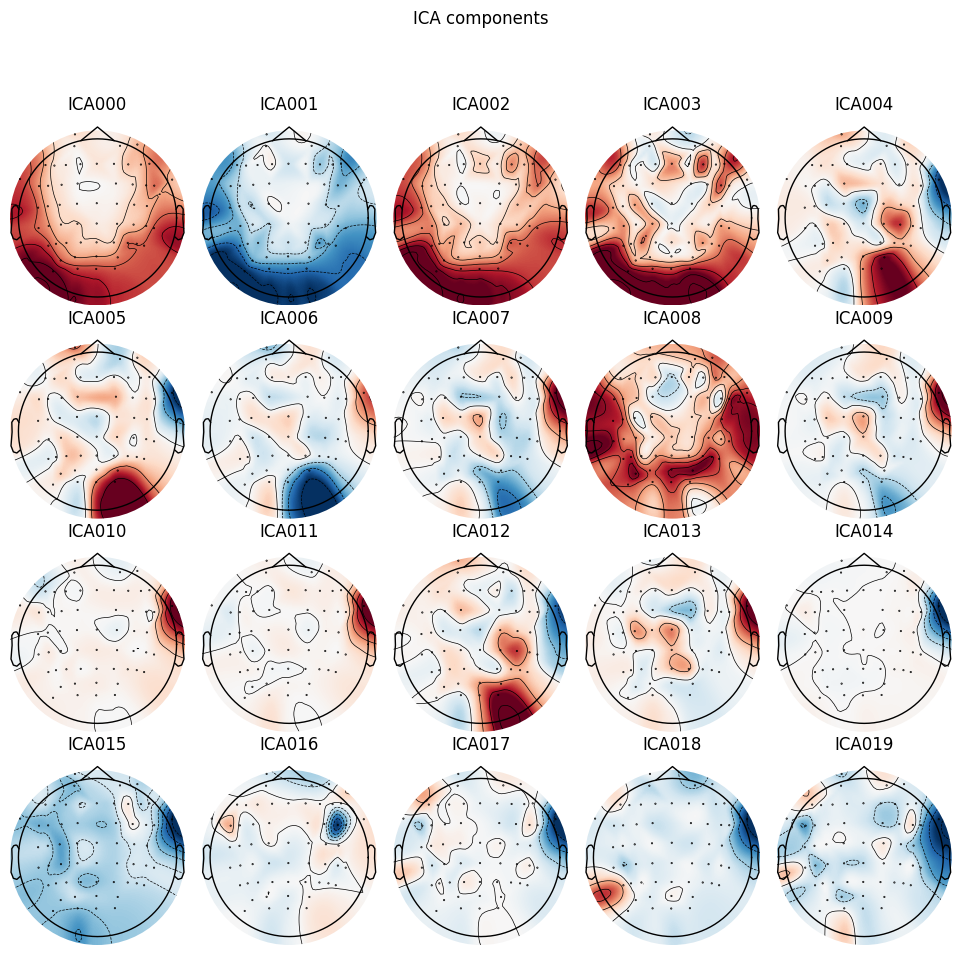

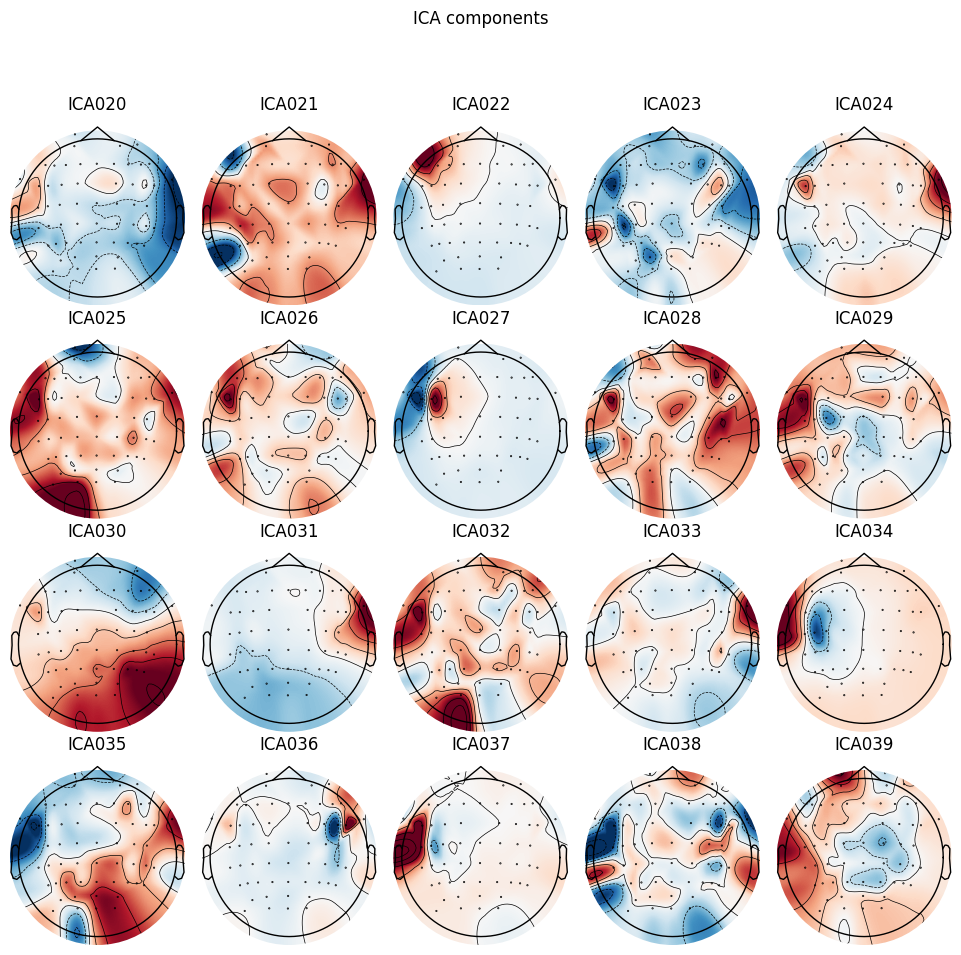

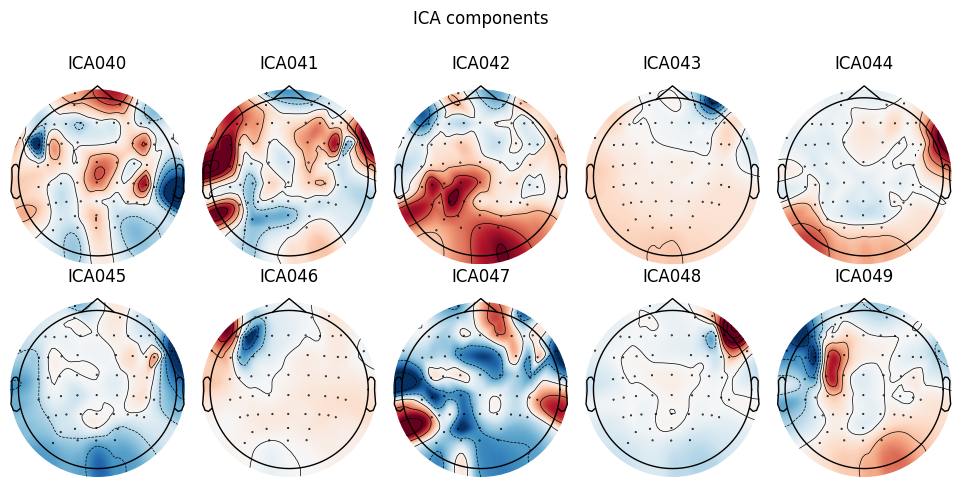

In [12]:
ica = ica_thing(50, epochs)

In [13]:
ica.plot_sources(epochs);

Not setting metadata
31 matching events found
No baseline correction applied
0 projection items activated


In [14]:
_epochs = epochs.copy()
ica.exclude = [0,1,2,3,8,14,47]

# ica.apply() changes the Raw object in-place, so let's make a copy first:

_epochs.load_data()
ica.apply(_epochs)

_epochs.plot();

Applying ICA to Epochs instance
    Transforming to ICA space (50 components)
    Zeroing out 7 ICA components
    Projecting back using 57 PCA components
Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
none


In [22]:
post_ica = _epochs.copy()
filtered_epochs = post_ica.copy().filter(1, 100)

Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 16501 samples (3.300 sec)



/tmp/ipykernel_4011/379746306.py:2: RuntimeWarning: filter_length (16501) is longer than the signal (9501), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_epochs = post_ica.copy().filter(1, 100)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1767 out of 1767 | elapsed:    5.1s finished


In [21]:
filtered_epochs.plot();

Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
none


In [23]:
filtered_epochs.drop([11,12,13,28,29])

Dropped 5 epochs: 11, 12, 13, 28, 29


Number of events,26
Events,1: 12: 25
Time range,-0.100 – 1.800 sec
Baseline,off


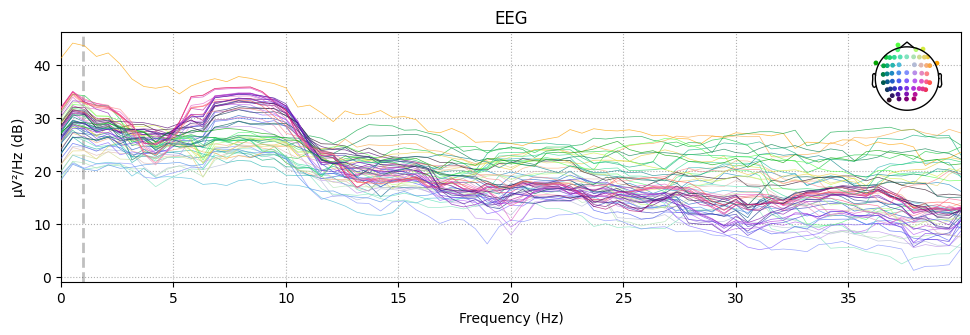

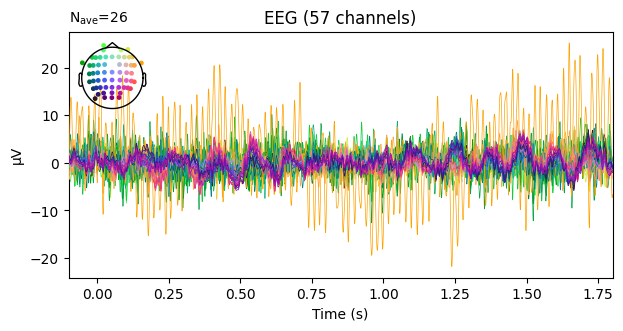

In [24]:
evoked = filtered_epochs.copy().average()
evoked.plot();

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows


/external/rprshnas01/kcni/moveisi/envs/course/lib/python3.9/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


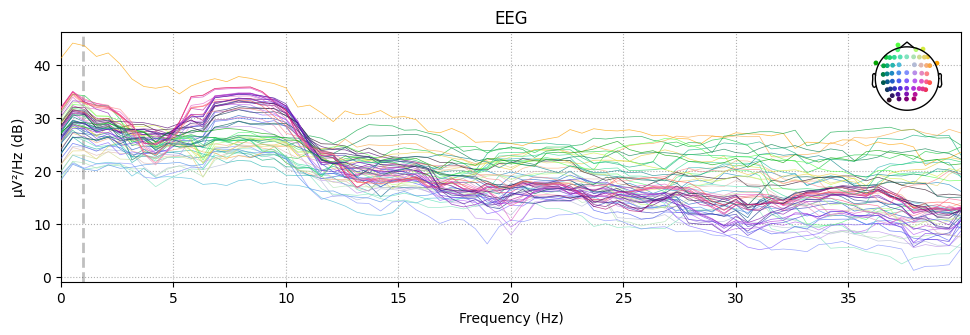

In [18]:
evoked.plot_psd(fmax=40)

In [27]:
evoked_fname = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/po/lab/repos/bme1500/po_scratch/evoked-ave.fif'
evoked.save(evoked_fname)